In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, brier_score_loss, balanced_accuracy_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import warnings
import math
from google.colab import files, drive
import pickle
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
#%store -r xgb_model
with open('/content/drive/My Drive/IEEE_dataset/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
#%store -r filtered_trainDF
filtered_trainDF = pd.read_pickle('/content/drive/My Drive/IEEE_dataset/filtered_trainDF.pkl')
#%store -r testDF
testDF = pd.read_pickle('/content/drive/My Drive/IEEE_dataset/testDF.pkl')

In [3]:
X = filtered_trainDF.drop(columns=['isFraud'])  # Features
y = filtered_trainDF['isFraud']  # Target

for col in X.columns:
    if X[col].dtype == 'datetime64[ns]' or 'Timestamp' in col:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype('int64')  # Convert to timestamp (int)

label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object' or isinstance(X[col].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, setting problematic entries to NaN

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].mean())  # Numeric columns: fill with mean
    else:
        X[col] = X[col].fillna(X[col].mode()[0])  # Non-numeric columns: fill with mode

print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

TransactionID               int64
TransactionDT               int64
TransactionAmt            float64
ProductCD                   int64
card1                       int64
                           ...   
Card_Transaction_Mean     float64
Card_Transaction_Std      float64
Card_Transaction_Count      int64
Fraud_Prob                float64
card4_freq                float64
Length: 450, dtype: object
X_train shape: (423354, 450)
y_train shape: (423354,)


# --------------------------------------------------------------------------------------

# Grid Search Best Estimator Analysis

In [4]:
param_grid = {
    'n_estimators': [1, 3, 5],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

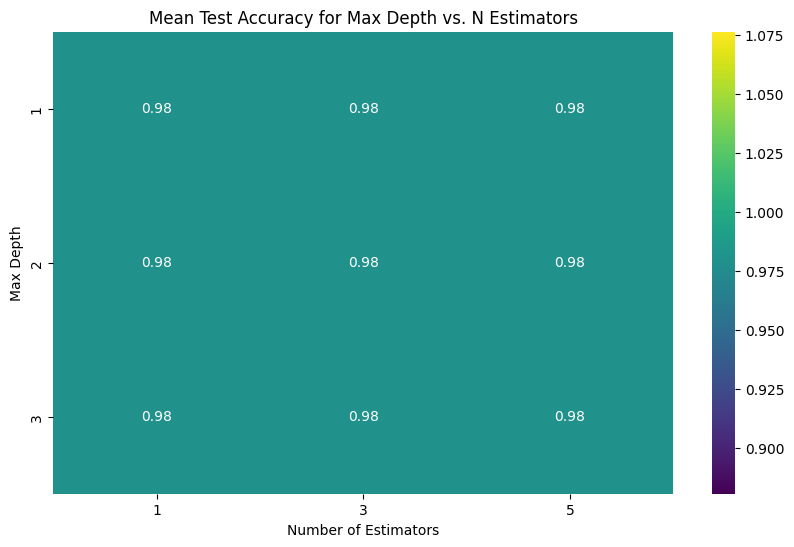

In [5]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data for a heatmap (example for 'max_depth' vs 'n_estimators')
pivot_table = results_df.pivot_table(values='mean_test_score',
                                     index='param_max_depth',
                                     columns='param_n_estimators')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean Test Accuracy for Max Depth vs. N Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

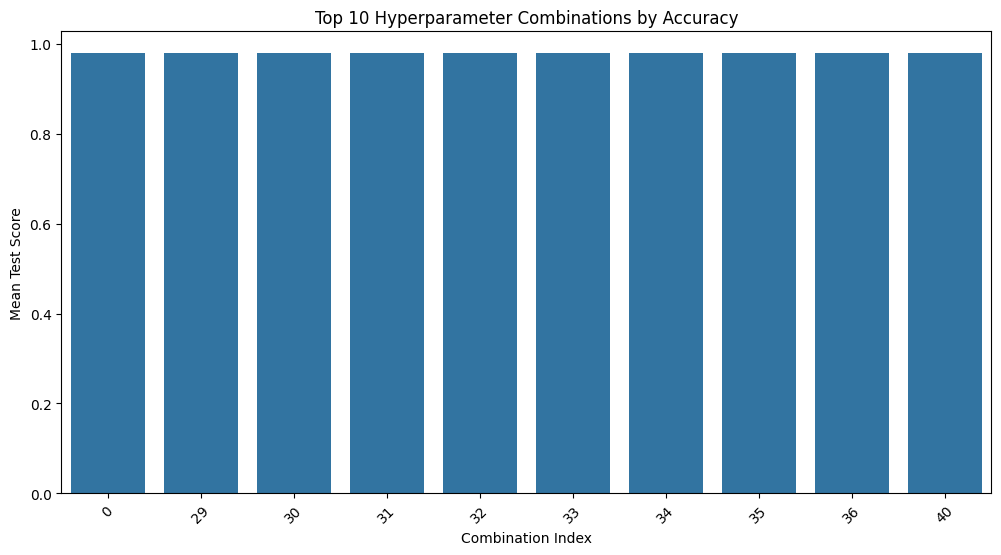

In [6]:
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_results.index, y=top_results['mean_test_score'])
plt.title('Top 10 Hyperparameter Combinations by Accuracy')
plt.ylabel('Mean Test Score')
plt.xlabel('Combination Index')
plt.xticks(rotation=45)
plt.show()

# --------------------------------------------------------------------------------------

# Top 10 Features Analysis

In [ ]:
top_n = 10
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(top_n).index

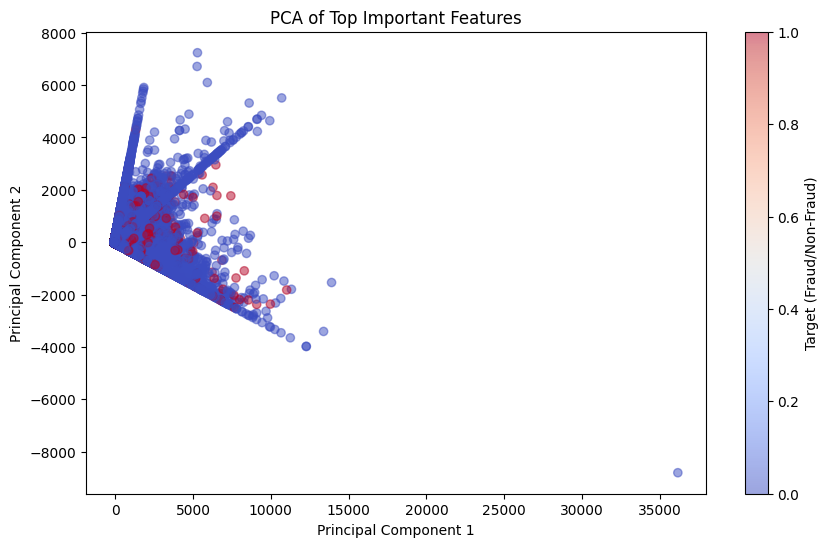

In [ ]:
X_reduced = X[top_features]
pca = PCA(n_components=2)  # Change the number of components as needed
X_pca = pca.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Top Important Features')
plt.colorbar(label='Target (Fraud/Non-Fraud)')
plt.show()

In [ ]:
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]
grid_search_top_features = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search_top_features.fit(X_train_top_features, y_train)

best_model_top_features = grid_search_top_features.best_estimator_
y_pred = best_model_top_features.predict(X_test_top_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the tuned model using top 10 features: {accuracy:.4f}")

Accuracy of the tuned model using top 10 features: 0.9782


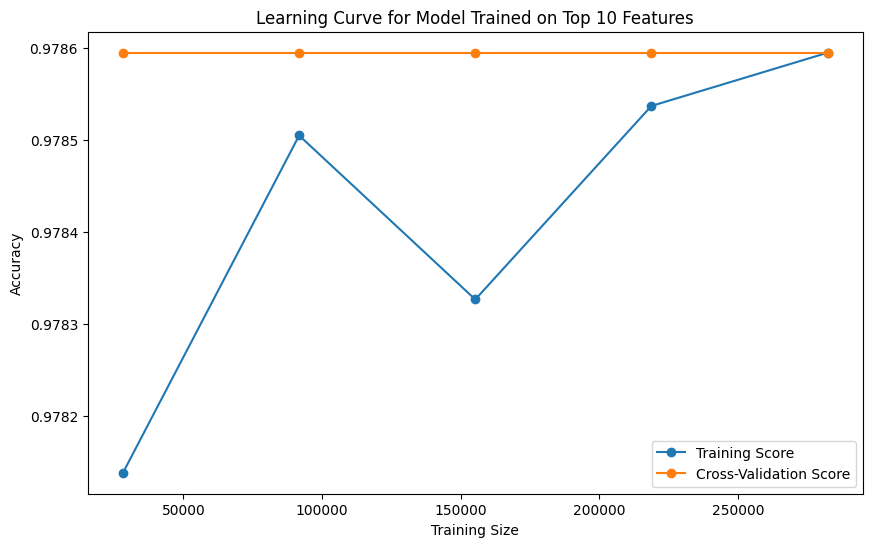

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model_top_features,
                                                        X_train_top_features,
                                                        y_train, cv=3, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve for Model Trained on Top 10 Features')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Accuracy of XGBoost on combined data: 0.9810


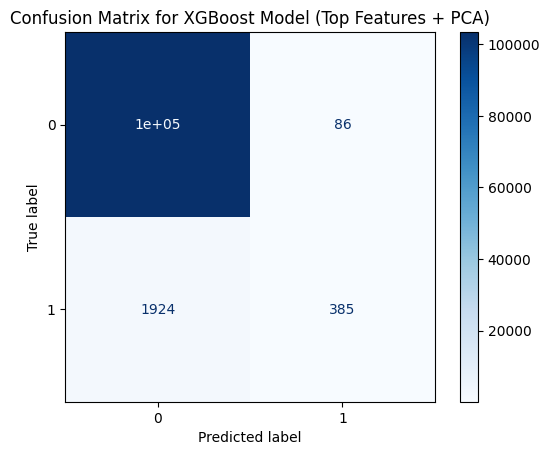

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Combine original top features and PCA components
X_combined = np.hstack([X_reduced, X_pca])

# Split the data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model_combined = XGBClassifier()
xgb_model_combined.fit(X_train_combined, y_train)

# Generate predictions
y_pred_combined = xgb_model_combined.predict(X_test_combined)

# Calculate accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f'Accuracy of XGBoost on combined data: {accuracy_combined:.4f}')

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_combined.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model (Top Features + PCA)')
plt.show()

In [ ]:
print(X_train_combined[0].size)

12


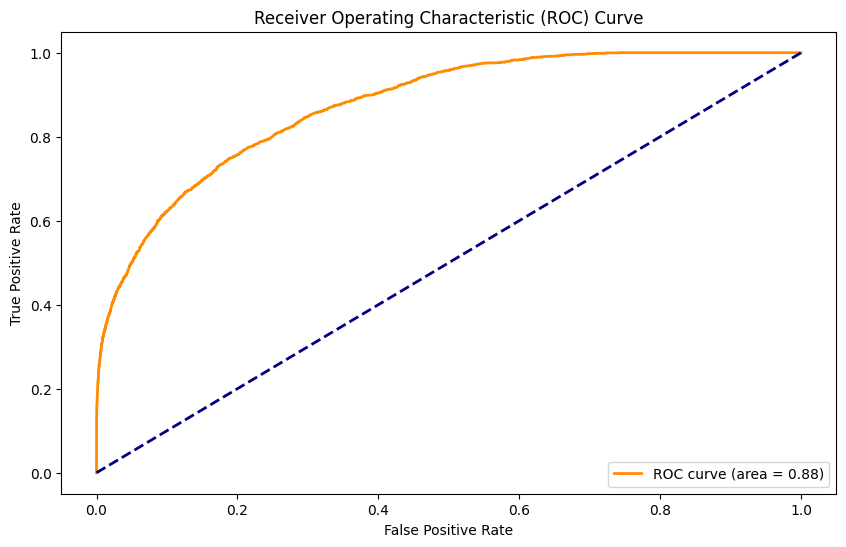

In [ ]:
y_prob = xgb_model_combined.predict_proba(X_test_combined)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

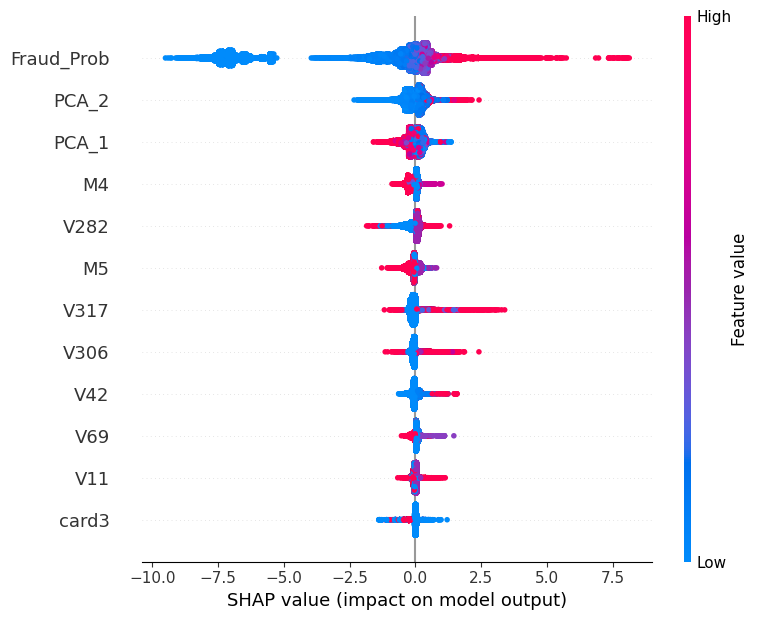

In [ ]:
X_test_combined_df = pd.DataFrame(X_test_combined, columns=list(top_features) + ["PCA_1", "PCA_2"])

# Re-run the SHAP explainer with the DataFrame that includes column names
explainer = shap.TreeExplainer(xgb_model_combined)
shap_values = explainer.shap_values(X_test_combined_df)

# Summary plot with labeled features
shap.summary_plot(shap_values, X_test_combined_df)

# --------------------------------------------------------------------------------------

# Ensemble Method: Stacking + Blending

In [ ]:
estimators = [
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression())
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_combined, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier()),
                               ('lr', LogisticRegression())],
                   final_estimator=LogisticRegression())

Accuracy: 0.9814
Precision: 0.7263
Recall: 0.2391
F1 Score: 0.3597
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    103530
           1       0.73      0.24      0.36      2309

    accuracy                           0.98    105839
   macro avg       0.85      0.62      0.68    105839
weighted avg       0.98      0.98      0.98    105839



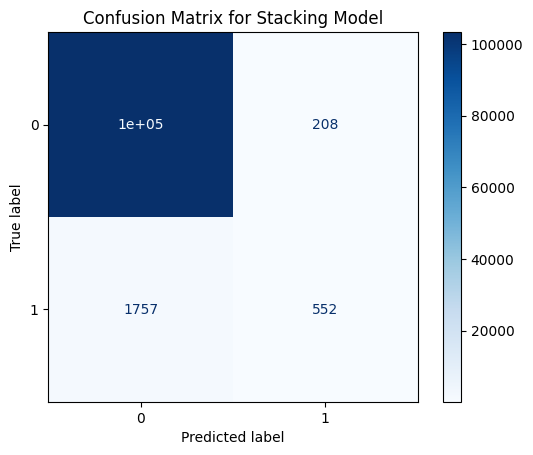

In [ ]:
y_pred = stacking_model.predict(X_test_combined)
y_prob = stacking_model.predict_proba(X_test_combined)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

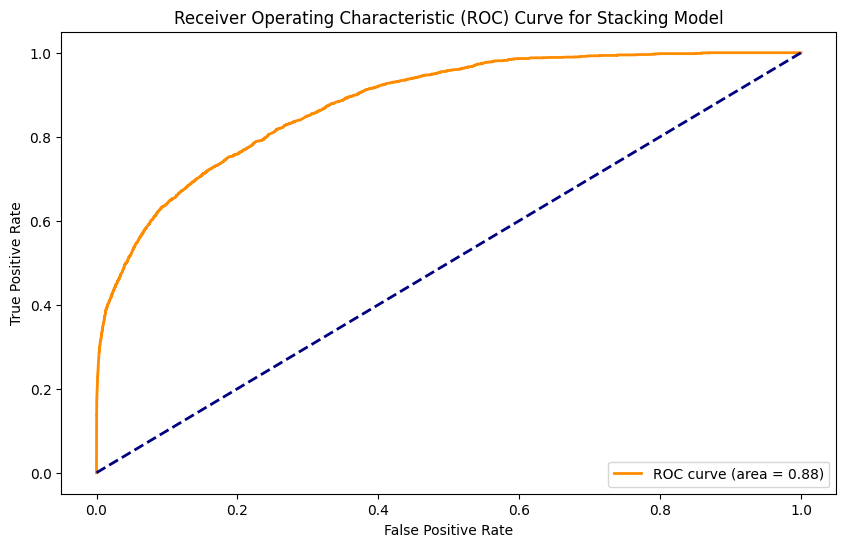

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Model')
plt.legend(loc='lower right')
plt.show()

# --------------------------------------------------------------------------------------

# Voting Model (Do not run again (takes too long), results are final)

In [ ]:
voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=[0.4, 0.3, 0.3]
)
weight_options = [
    [0.5, 0.3, 0.2],
    [0.6, 0.2, 0.2],
    [0.4, 0.4, 0.2],
    [0.3, 0.3, 0.4],
    [0.3, 0.4, 0.3],
    [0.7, 0.2, 0.1],
    [0.7, 0.1, 0.2]
]

best_score = 0
best_weights = None

# Iterate through different weight options
for weights in weight_options:
    voting_model.set_params(weights=weights)
    scores = cross_val_score(voting_model, X_train_combined, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_weights = weights

print(f"Best Weights: {best_weights} with Accuracy: {best_score:.4f}")

Best Weights: [0.7, 0.2, 0.1] with Accuracy: 0.9813


# --------------------------------------------------------------------------------------

# Repeated Nested Cross Validation

## Lasso for Feature Selection

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Convert to Numpy arrays for compatibility with Scikit-Learn
X_train = np.array(X_train)
y_train = np.array(y_train)

# Step 2: Define Outer and Inner Cross-Validation
# The outer CV is used to evaluate the model, and the inner CV is used for hyperparameter tuning
# Ensure that outer and inner loops have different random states to avoid overlapping splits
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)  # CHANGE RANDOM STATE to ensure non-overlapping indices
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=84)  # Different random state from outer_cv

# Step 3: Define Base Models
# These models will be used in the Voting Classifier ensemble
xgb_model_2 = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_model = LogisticRegression(random_state=42)

num_features = 450
lower_bound_depth = int(np.floor(np.log2(num_features)))  # Approximate lower bound
upper_bound_depth = num_features  # Upper bound is the total number of features

# Define new depth range based on the heuristic
depth_range = [lower_bound_depth, lower_bound_depth + 2, int(upper_bound_depth / 2)]

# Updated parameter grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': depth_range,  # Adjusted based on number of features
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize lists to store metrics for each outer fold
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []

# Step 4: Nested Repeated Cross-Validation Loop
# Creating consensus feature so that in different loops different selections of features are taken into account
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Feature Selection using LASSO Regression in the Inner Loop
    # Using LASSO (LassoCV) for feature selection based on the value of coefficients
    # Look for n_alphas parameter in LassoCV and ensure cross-validation is consistent
    lasso = LassoCV(cv=inner_cv, random_state=42).fit(X_outer_train, y_outer_train)  # Use inner_cv for consistency
    selected_features = np.where(lasso.coef_ != 0)[0]  # Select features with non-zero coefficients

    # Reduce the training and test set to only the selected features
    X_outer_train = X_outer_train[:, selected_features]
    X_outer_test = X_outer_test[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV
    # This is meaningful only after feature selection to optimize hyperparameters on a refined feature set
    random_search = RandomizedSearchCV(
        estimator=xgb_model_2,
        param_distributions=param_grid,
        n_iter=10,  # Number of iterations for Randomized Search
        scoring='accuracy',
        cv=inner_cv,  # Use inner_cv for hyperparameter tuning
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_  # Get the best model from the inner loop

    # Define the Voting Classifier with the tuned model
    # The voting classifier combines multiple models to improve performance
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',  # Soft voting averages predicted probabilities
        weights=[0.7, 0.2, 0.1]  # Assign different weights to different models
    )

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the voting model on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1]  # Predicted probabilities for ROC-AUC

    # Store metrics for each outer fold
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred))
    outer_recall.append(recall_score(y_outer_test, y_pred))
    outer_f1.append(f1_score(y_outer_test, y_pred))
    outer_roc_auc.append(roc_auc_score(y_outer_test, y_prob))

# Print average metrics across all outer folds
print(f"Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")
print(f"ROC-AUC Score: {np.mean(outer_roc_auc):.4f} ± {np.std(outer_roc_auc):.4f}")



X_train shape: (423354, 450)
y_train shape: (423354,)
Accuracy: 0.9786 ± 0.0000
Precision: 0.0000 ± 0.0000
Recall: 0.0000 ± 0.0000
F1 Score: 0.0000 ± 0.0000
ROC-AUC Score: 0.5706 ± 0.0047


In [8]:
# Step 5: Final Model Training on the Entire Dataset
# The final voting model is trained on the entire dataset using the selected features
voting_model.fit(X_train[:, selected_features], y_train)

# Step 6: Evaluate the Final Model on the Independent Test Set
# Apply the same feature selection to the independent test set
X_test = np.array(X_test)
X_test_selected = X_test[:, selected_features]
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1]

# Calculate and print final metrics for the independent test set
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")

Final Model Accuracy: 0.9782
Final Model Precision: 0.0000
Final Model Recall: 0.0000
Final Model F1 Score: 0.0000
Final Model ROC-AUC Score: 0.5755


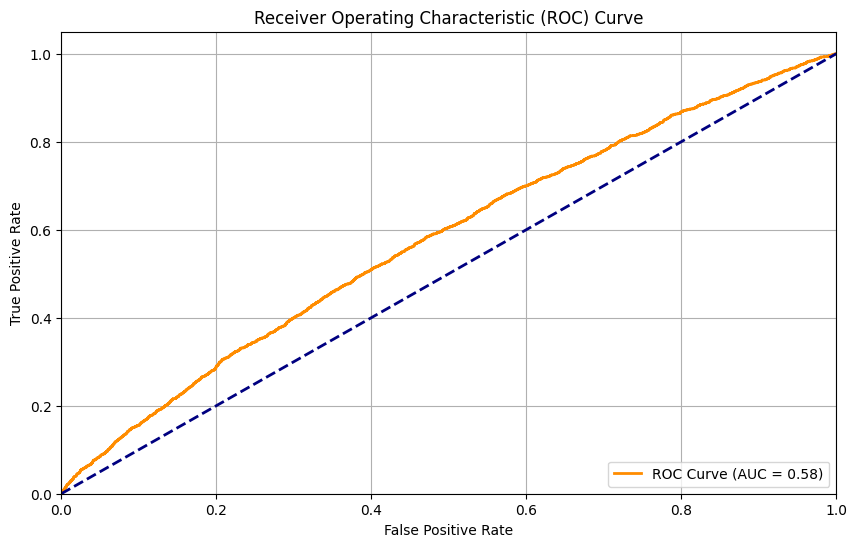

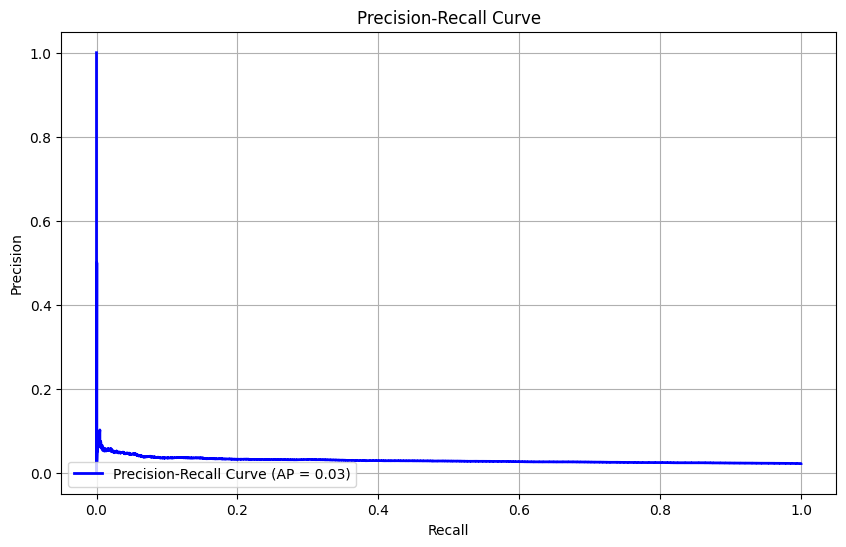

Average Precision Score: 0.0296


In [9]:
fpr, tpr, _ = roc_curve(y_test, y_final_prob)
roc_auc = auc(fpr, tpr)

# Step 2: Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 3: Compute Precision-Recall Curve and Average Precision Score
precision, recall, _ = precision_recall_curve(y_test, y_final_prob)
avg_precision = average_precision_score(y_test, y_final_prob)

# Step 4: Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Step 5: Print Average Precision Score
print(f"Average Precision Score: {avg_precision:.4f}")

# RFE For Feature Selection

In [10]:
# Step 1: Define Outer and Inner Cross-Validation
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)  # Reduced splits and repeats
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=84)

# Step 2: Define Base Models
xgb_model_2 = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_model = LogisticRegression(random_state=42)

# Updated parameter grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100],  # Reduced options
    'max_depth': [3, 6],        # Simpler depth range
    'learning_rate': [0.1],     # Fixed learning rate
    'subsample': [0.8]          # Fixed subsample
}

# Initialize lists to store metrics for each outer fold
outer_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

# Step 3: Nested Cross-Validation Loop
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Feature Selection: Use feature importances from RF instead of RFE
    rf_model.fit(X_outer_train, y_outer_train)
    feature_importances = rf_model.feature_importances_
    selected_features = np.argsort(feature_importances)[-50:]  # Top 50 features

    # Reduce the training and test sets to selected features
    X_outer_train = X_outer_train[:, selected_features]
    X_outer_test = X_outer_test[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model_2,
        param_distributions=param_grid,
        n_iter=3,  # Further reduced iterations
        scoring='accuracy',
        cv=inner_cv,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Define the Voting Classifier
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='hard'  # Changed to 'hard' for faster computation
    )

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the voting model on the outer test set
    y_pred = voting_model.predict(X_outer_test)
    y_prob = voting_model.predict_proba(X_outer_test)[:, 1] if hasattr(voting_model, 'predict_proba') else None

    # Store metrics for each outer fold
    outer_metrics['accuracy'].append(accuracy_score(y_outer_test, y_pred))
    outer_metrics['precision'].append(precision_score(y_outer_test, y_pred))
    outer_metrics['recall'].append(recall_score(y_outer_test, y_pred))
    outer_metrics['f1'].append(f1_score(y_outer_test, y_pred))
    if y_prob is not None:
        outer_metrics['roc_auc'].append(roc_auc_score(y_outer_test, y_prob))

# Print average metrics across all outer folds
for metric, values in outer_metrics.items():
    if values:  # Skip if metric was not computed
        print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Step 4: Final Model Training on the Entire Dataset
# Use feature importances from RF for final feature selection
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_
selected_features_final = np.argsort(feature_importances)[-50:]  # Top 50 features

X_train_selected = X_train[:, selected_features_final]
X_test_selected = X_test[:, selected_features_final]

# Train the final voting model on the full training set
voting_model.fit(X_train_selected, y_train)

# Evaluate the final model on the independent test set
y_final_pred = voting_model.predict(X_test_selected)
y_final_prob = voting_model.predict_proba(X_test_selected)[:, 1] if hasattr(voting_model, 'predict_proba') else None

# Calculate and print final metrics
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)
final_roc_auc = roc_auc_score(y_test, y_final_prob) if y_final_prob is not None else None

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")
if final_roc_auc is not None:
    print(f"Final Model ROC-AUC Score: {final_roc_auc:.4f}")


Accuracy: 0.9828 ± 0.0001
Precision: 0.9737 ± 0.0073
Recall: 0.1996 ± 0.0035
F1: 0.3313 ± 0.0047
Final Model Accuracy: 0.9828
Final Model Precision: 0.9691
Final Model Recall: 0.2170
Final Model F1 Score: 0.3546


# Feature Importance For Feature Selection

In [14]:
# Print dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Convert to Numpy arrays for compatibility with Scikit-Learn
X_train = np.array(X_train)
y_train = np.array(y_train)

# Step 1: Define Outer and Inner Cross-Validation
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)  # Reduced splits and repeats
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=84)  # Reduced splits and repeats

# Step 2: Define Base Models
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
lr_model = LogisticRegression(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1],  # Fixed learning rate
    'subsample': [0.8]  # Fixed subsample
}

# Initialize lists to store metrics for each outer fold
outer_accuracy = []
outer_precision = []
outer_recall = []
outer_f1 = []
outer_roc_auc = []

# Step 3: Nested Repeated Cross-Validation Loop
for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split outer training and test sets
    X_outer_train, X_outer_test = X_train[train_index], X_train[test_index]
    y_outer_train, y_outer_test = y_train[train_index], y_train[test_index]

    # Feature Selection using Feature Importance from XGBoost
    xgb_model.fit(X_outer_train, y_outer_train)
    feature_importances = xgb_model.feature_importances_
    selected_features = np.argsort(feature_importances)[-30:]  # Select top 30 features

    # Reduce the training and test set to only the selected features
    X_outer_train = X_outer_train[:, selected_features]
    X_outer_test = X_outer_test[:, selected_features]

    # Hyperparameter Tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=5,  # Reduced iterations
        scoring='accuracy',
        cv=inner_cv,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_outer_train, y_outer_train)
    best_xgb_model = random_search.best_estimator_

    # Define the Voting Classifier
    estimators = [
        ('xgb', best_xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ]
    voting_model = VotingClassifier(
        estimators=estimators,
        voting='hard',  # Changed to 'hard' voting
        weights=[0.7, 0.2, 0.1]
    )

    # Train the voting model on the outer training set
    voting_model.fit(X_outer_train, y_outer_train)

    # Evaluate the voting model on the outer test set
    y_pred = voting_model.predict(X_outer_test)

    # Store metrics for each outer fold
    outer_accuracy.append(accuracy_score(y_outer_test, y_pred))
    outer_precision.append(precision_score(y_outer_test, y_pred))
    outer_recall.append(recall_score(y_outer_test, y_pred))
    outer_f1.append(f1_score(y_outer_test, y_pred))
    # Skip ROC-AUC for faster runtime (can be added back if needed)

# Print average metrics across all outer folds
print(f"Accuracy: {np.mean(outer_accuracy):.4f} ± {np.std(outer_accuracy):.4f}")
print(f"Precision: {np.mean(outer_precision):.4f} ± {np.std(outer_precision):.4f}")
print(f"Recall: {np.mean(outer_recall):.4f} ± {np.std(outer_recall):.4f}")
print(f"F1 Score: {np.mean(outer_f1):.4f} ± {np.std(outer_f1):.4f}")

# Step 4: Final Model Training on the Entire Dataset
xgb_model.fit(X_train, y_train)
feature_importances_final = xgb_model.feature_importances_
selected_features_final = np.argsort(feature_importances_final)[-30:]  # Select top 30 features

X_train_selected = X_train[:, selected_features_final]
X_test_selected = X_test[:, selected_features_final]

voting_model.fit(X_train_selected, y_train)

# Evaluate the final model on the independent test set
y_final_pred = voting_model.predict(X_test_selected)

# Calculate and print final metrics
final_accuracy = accuracy_score(y_test, y_final_pred)
final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)

print(f"Final Model Accuracy: {final_accuracy:.4f}")
print(f"Final Model Precision: {final_precision:.4f}")
print(f"Final Model Recall: {final_recall:.4f}")
print(f"Final Model F1 Score: {final_f1:.4f}")

X_train shape: (423354, 450)
y_train shape: (423354,)
Accuracy: 0.9818 ± 0.0000
Precision: 0.8301 ± 0.0075
Recall: 0.1895 ± 0.0048
F1 Score: 0.3085 ± 0.0059
Final Model Accuracy: 0.9815
Final Model Precision: 0.8272
Final Model Recall: 0.1949
Final Model F1 Score: 0.3155
